In [1]:
from IPython import display

from matplotlib import pyplot as plt
%matplotlib inline

import math, itertools

import tensorflow as tf
from scipy import special
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
IMAGE_PIXELS = 28*28
NOISE_SIZE = 100

In [3]:
def noise(n_rows, n_cols):
    return np.random.normal(size=(n_rows, n_cols))

def xavier_init(size):
    in_dim = size[0] if len(size) == 1 else size[1]
    stddev = 1. / math.sqrt(float(in_dim))
    return tf.random_uniform(shape=size, minval=-stddev, maxval=stddev)

## Load Data

In [4]:
# No rescaling needed. MNIST data is in range [0, 1]
mnist = input_data.read_data_sets("tf_data/")
mnist_data = (mnist.train.images - .5 ) / .5
np.random.shuffle(mnist_data)

Extracting tf_data/train-images-idx3-ubyte.gz
Extracting tf_data/train-labels-idx1-ubyte.gz
Extracting tf_data/t10k-images-idx3-ubyte.gz
Extracting tf_data/t10k-labels-idx1-ubyte.gz


## Initialize Graph

In [5]:
## Discriminator

# Input
X = tf.placeholder(tf.float32, shape=(None, IMAGE_PIXELS))

# Layer 1 Variables
D_W1 = tf.Variable(xavier_init([784, 1024]))
D_B1 = tf.Variable(xavier_init([1024]))

# Layer 2 Variables
D_W2 = tf.Variable(xavier_init([1024, 512]))
D_B2 = tf.Variable(xavier_init([512]))

# Layer 3 Variables
D_W3 = tf.Variable(xavier_init([512, 256]))
D_B3 = tf.Variable(xavier_init([256]))

# Out Layer Variables
D_W4 = tf.Variable(xavier_init([256, 1]))
D_B4 = tf.Variable(xavier_init([1]))

# Store Variables in list
D_var_list = [D_W1, D_B1, D_W2, D_B2, D_W3, D_B3, D_W4, D_B4]

In [6]:
## Generator

# Input
Z = tf.placeholder(tf.float32, shape=(None, NOISE_SIZE))

# Layer 1 Variables
G_W1 = tf.Variable(xavier_init([100, 256]))
G_B1 = tf.Variable(xavier_init([256]))

# Layer 2 Variables
G_W2 = tf.Variable(xavier_init([256, 512]))
G_B2 = tf.Variable(xavier_init([512]))

# Layer 3 Variables
G_W3 = tf.Variable(xavier_init([512, 1024]))
G_B3 = tf.Variable(xavier_init([1024]))

# Out Layer Variables
G_W4 = tf.Variable(xavier_init([1024, 784]))
G_B4 = tf.Variable(xavier_init([784]))

# Store Variables in list
G_var_list = [G_W1, G_B1, G_W2, G_B2, G_W3, G_B3, G_W4, G_B4]

In [7]:
def discriminator(x):
    l1 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(x,   D_W1) + D_B1, .2), .3)
    l2 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(l1,  D_W2) + D_B2, .2), .3)
    l3 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(l2,  D_W3) + D_B3, .2), .3)
    out = tf.matmul(l3, D_W4) + D_B4
    return out

def generator(z):
    l1 = tf.nn.leaky_relu(tf.matmul(z,  G_W1) + G_B1, .2)
    l2 = tf.nn.leaky_relu(tf.matmul(l1, G_W2) + G_B2, .2)
    l3 = tf.nn.leaky_relu(tf.matmul(l2, G_W3) + G_B3, .2)
    out = tf.nn.tanh(tf.matmul(l3, G_W4) + G_B4)
    return out

In [8]:
G_sample = generator(Z)
D_real = discriminator(X)
D_fake = discriminator(G_sample)

# Losses
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))

# Optimizers
D_opt = tf.train.AdamOptimizer(2e-4).minimize(D_loss, var_list=D_var_list)
G_opt = tf.train.AdamOptimizer(2e-4).minimize(G_loss, var_list=G_var_list)

## Train

In [9]:
BATCH_SIZE = 100
NUM_EPOCHS = 200

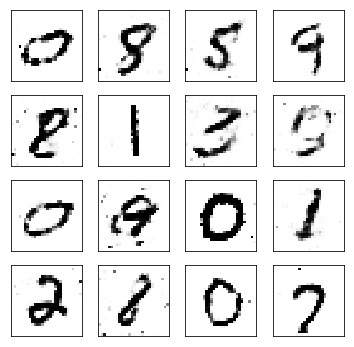

Epoch: 199 Batch: 500
Discriminator Loss: 1.3507, Generator Loss: 0.7361
D(x): 0.5094, D(G(z)): 0.4833


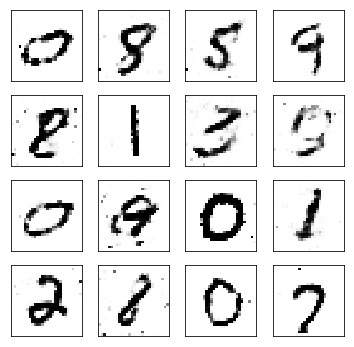

In [10]:
# create figure for plotting
size_figure_grid = int(math.sqrt(16))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)


# Start interactive session
session = tf.InteractiveSession()
# Init Variables
tf.global_variables_initializer().run()

# Iterate through epochs
for epoch in range(NUM_EPOCHS):
    for n_batch in range(mnist_data.shape[0] // BATCH_SIZE):
        # Train Discriminator
        X_batch = mnist_data[ (n_batch * BATCH_SIZE):(n_batch * BATCH_SIZE)+BATCH_SIZE]
        feed_dict = {X: X_batch, Z: noise(BATCH_SIZE, NOISE_SIZE)}
        _, D_loss_i, D_real_i, D_fake_i = session.run([D_opt, D_loss, D_real, D_fake], feed_dict=feed_dict)

        # Train Generator
        feed_dict = {Z: noise(BATCH_SIZE, NOISE_SIZE)}
        _, G_loss_i, G_sample_i = session.run([G_opt, G_loss, G_sample], feed_dict=feed_dict)

        if n_batch % 100 == 0:
            display.clear_output(True)
            for k in range(16):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(G_sample_i[k,:].reshape(28, 28), cmap='Greys')
            display.display(plt.gcf())
            print('Epoch: {} Batch: {}'.format(epoch, n_batch))
            print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(D_loss_i, G_loss_i))
            print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(
                special.expit(D_real_i).mean(), special.expit(D_fake_i).mean()))